In [1]:
%matplotlib ipympl
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch
import sys
import pywt
import util

# interactive plotting with %matplotlib notebook
!ls ../../recordings

2025-05-12_17-00_gain24_boardAds1299_vref4.5.csv
2025-05-12_17-22_gain24_boardAds1299_vref4.5.csv


In [2]:
print('Load data and get properties\n')

# fname = '8ch.csv'
fname = '2025-05-12_17-22_gain24_boardAds1299_vref4.5.csv'
df = pd.read_csv(f"../../recordings/{fname}")
fname = '2025-05-12_17-22_gain24_boardAds1299_vref4.5.csv'

board, gain, Fs, vref, avss, resolution, vmid = util.get_board_attributes(fname)
channel_count = len([i for i in list(df.columns) if i.find('_raw_sample') !=-1])
len_minutes = (df['timestamp'].iloc[-1]-df['timestamp'].iloc[0])/1000000. / 60.

print(f"vref={vref}V, avss={avss}V, gain={gain}, sample_rate={Fs}hz, vmid={vmid}, resolution={resolution} bit")
print(f"\nchannel count= {channel_count}")
print(f"\ndata length= {int(len_minutes)}min {int((len_minutes%1)*60)}sec")

Load data and get properties

vref=4.5V, avss=0V, gain=24.0, sample_rate=250.0hz, vmid=2.25, resolution=24 bit

channel count= 2

data length= 5min 15sec


In [3]:
from scipy.signal import welch
import matplotlib.pyplot as plt

def plot_psd_comparison(df_raw, df_ds, col, fs_raw=500, fs_ds=250):
    """Welch PSD before vs. after down‑sampling one channel."""
    f1, P1 = welch(df_raw[col], fs_raw, nperseg=4*fs_raw)
    f2, P2 = welch(df_ds[col],  fs_ds, nperseg=4*fs_ds)

    plt.semilogy(f1, P1, label=f'{fs_raw} Hz')
    plt.semilogy(f2, P2, '--', label=f'{fs_ds} Hz  (↓)')
    plt.axvline(fs_ds/2, color='grey', ls=':', lw=0.8)  # new Nyquist
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (V²/Hz)')
    plt.title(f'PSD check – channel {col}')
    plt.legend(); plt.grid()
    

added these new columns, ['time_sec', 'ch0_raw_voltage', 'ch1_raw_voltage']


,timestamp,ch0_voltage,ch1_voltage,ch0_raw_sample,ch1_raw_sample,time_sec,ch0_raw_voltage,ch1_raw_voltage
0,1747084800850943,0.000008,6.558366e-06,-843804,151549,10.000,2.231140,2.253388
1,1747084800854943,0.000006,4.770566e-06,-845027,149697,10.004,2.231113,2.253347
2,1747084800858943,0.000002,7.813543e-07,-841936,149806,10.008,2.231182,2.253350
3,1747084800862943,-0.000001,-3.539207e-06,-840332,154066,10.012,2.231217,2.253444
4,1747084800866943,-0.000002,-5.755037e-06,-842996,152619,10.016,2.231157,2.253411
...,...,...,...,...,...,...,...,...
68859,1747085076286943,-0.000004,-4.693465e-06,-816251,182489,285.436,2.231755,2.254078
68860,1747085076290943,-0.000004,-2.780872e-06,-812594,185048,285.440,2.231836,2.254135
68861,1747085076294943,-0.000001,6.495282e-08,-816867,177333,285.444,2.231741,2.253963
68862,1747085076298943,0.000001,8.403524e-07,-817608,181675,285.448,2.231725,2.254061


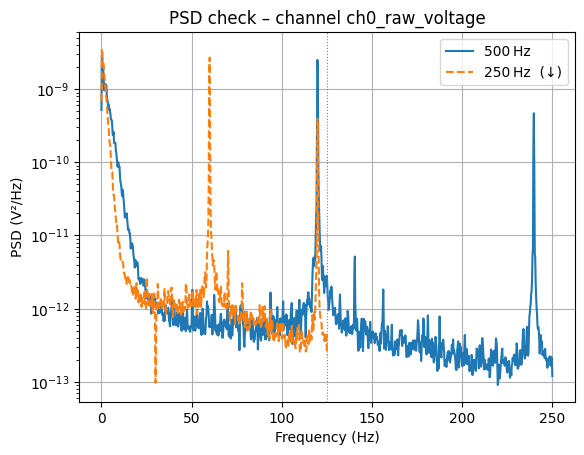

In [5]:
df = util.add_time_and_raw_voltage_columns(df, fname)

# Trime first and last
remove_first_seconds = 10
remove_last_seconds = 10
max_time = df['time_sec'].max()
df_original = df[(df['time_sec'] >= remove_first_seconds) & (df['time_sec'] <= (max_time - remove_last_seconds))].reset_index(drop=True)

raw_voltage_cols = util.get_raw_volt_cols(df)
df = util.remove_powerline_noise(df_original, raw_voltage_cols, fs=500, f0=60.0, q=60)
if False: # using 500sps
    util.downsample_by_half(df, raw_voltage_cols, fs_in=500)

plot_psd_comparison(df_original, df, col=raw_voltage_cols[0])
df

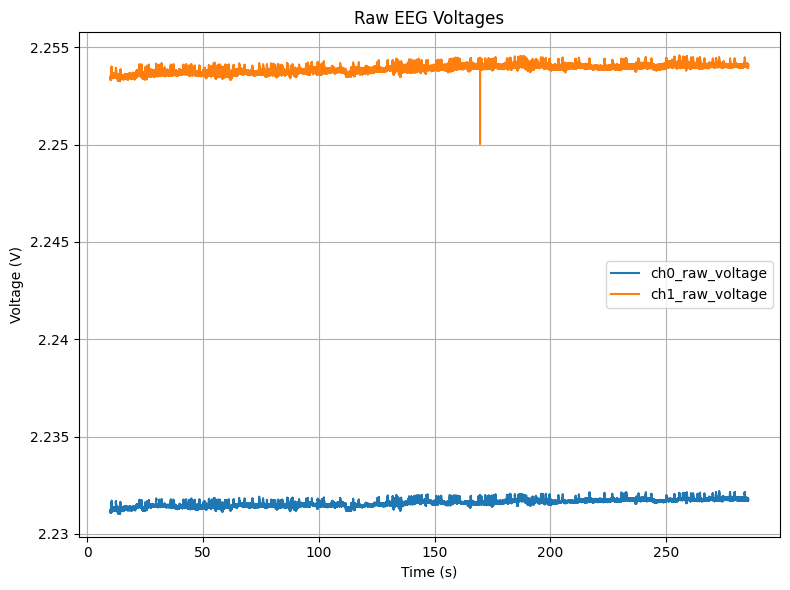

In [6]:
# time = df['time_sec'][df['time_sec'] >= 0]
raw_voltage_cols = util.get_raw_volt_cols(df)

# channels = ['ch1_raw_voltage', 'ch2_raw_voltage', 'ch3_raw_voltage', 'ch4_raw_voltage']
util.plot_raw_voltages(df, raw_voltage_cols)

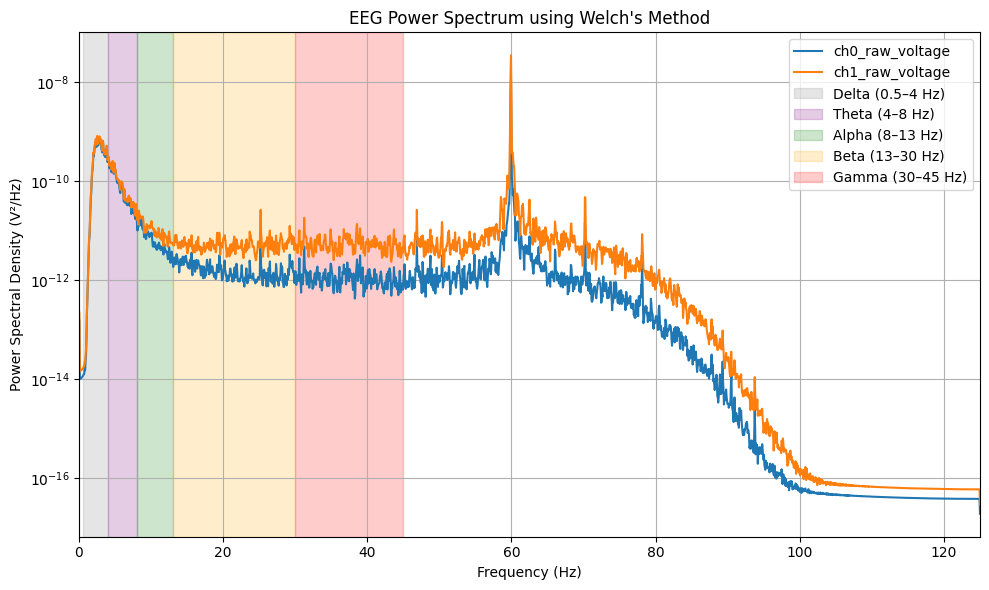

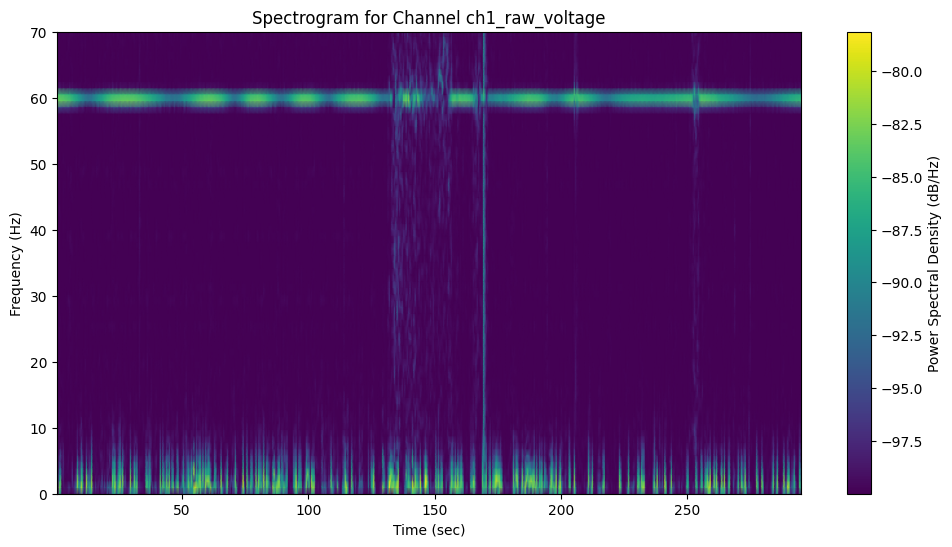

In [ ]:
# time = df['time_sec'][df['time_sec'] >= 0]
raw_voltage_cols = util.get_raw_volt_cols(df)

# channels = ['ch1_raw_voltage', 'ch2_raw_voltage', 'ch3_raw_voltage', 'ch4_raw_voltage']
util.plot_power_spectrum_welch(df, raw_voltage_cols, Fs, 2, 80, 4, 125)
_ = util.plot_spectrogram(df['ch1_raw_voltage'], Fs, 70)

/Users/nickgeoca/.pyenv/versions/3.13.3/lib/python3.13/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)


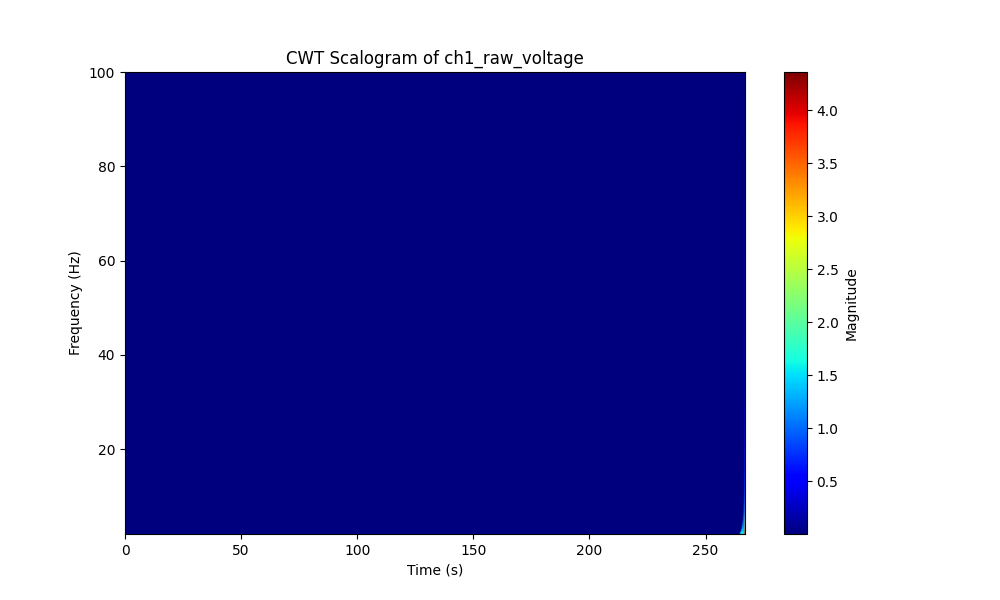

In [6]:
_ = util.plot_cwt(df['ch1_raw_voltage'], Fs, 2, 100, 196)